In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                    GridSearchCV)

from sklearn.metrics import (accuracy_score, 
                            f1_score, precision_score, 
                            confusion_matrix, 
                            classification_report,
                            confusion_matrix, roc_curve, auc)

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

## Business Problem

Tanzania has had a problem with available water to the general populace for many years.

The Tanzanian government has hired us to figure out a way to imporve methods in identifying non-functioning water wells.

We will be trying to detect which key features will help up identify the status of these wells. 

## Column Descriptions
amount_tsh - Total static head (amount water available to waterpoint)

date_recorded - The date the row was entered

funder - Who funded the well

gps_height - Altitude of the well

installer - Organization that installed the well

longitude - GPS coordinate

latitude - GPS coordinate

wpt_name - Name of the waterpoint if there is one

num_private -

basin - Geographic water basin

subvillage - Geographic location

region - Geographic location

region_code - Geographic location (coded)

district_code - Geographic location (coded)

lga - Geographic location

ward - Geographic location

population - Population around the well

public_meeting - True/False

recorded_by - Group entering this row of data

scheme_management - Who operates the waterpoint

scheme_name - Who operates the waterpoint

permit - If the waterpoint is permitted

construction_year - Year the waterpoint was constructed

extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint uses

extraction_type_class - The kind of extraction the waterpoint uses

management - How the waterpoint is managed

management_group - How the waterpoint is managed

payment - What the water costs

payment_type - What the water costs

water_quality - The quality of the water

quality_group - The quality of the water

quantity - The quantity of water

quantity_group - The quantity of water

source - The source of the water

source_type - The source of the water

source_class - The source of the water

waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint

In [2]:
independants = pd.read_csv("Data/Training_Set_Values.csv")
independants.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
dependants = pd.read_csv("Data/Training_Set_Labels.csv")
dependants.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


Looks like these are our independant and dependant variables. Going to merge them together for a df.

In [4]:
df = independants.merge(dependants, how='outer')
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

# Data Cleaning and Exploration

In [6]:
##Dropping id since it's irrelevant 
df = df.drop("id", axis=1)

In [7]:
df.duplicated().sum()

36

In [8]:
#Dropping duplicate rows
df.drop_duplicates(keep="first", inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3314
recorded_by                  0
scheme_management         3877
scheme_name              28139
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

scheme_name is missing about half it's values. Dropping it

In [11]:
df = df.drop("scheme_name", axis=1)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

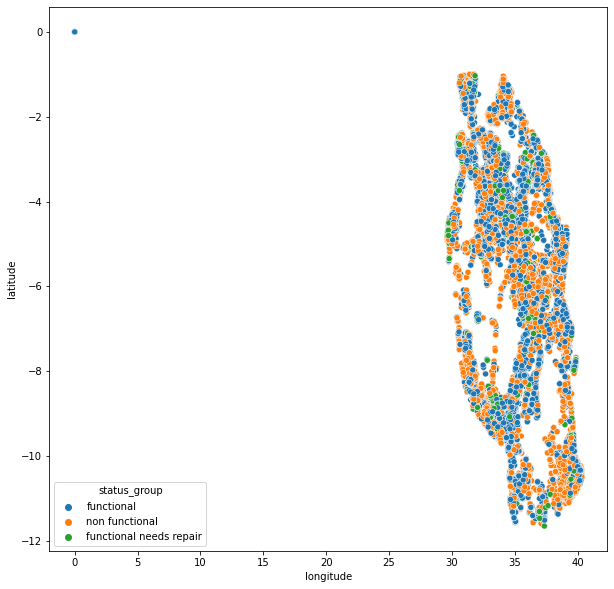

In [12]:
plt.figure(figsize = (10,10))
sns.scatterplot(x='longitude',y='latitude',hue='status_group',data=df)



Looks like 0 longitude and latitude is used as a placeholder for unknown locations. Let's remove the rows

In [13]:
df = df[df.longitude > 0]

In [14]:
df.longitude.value_counts()

39.090448    2
39.086287    2
39.086183    2
39.098514    2
39.093095    2
            ..
37.579803    1
33.196490    1
34.017119    1
33.788326    1
35.005922    1
Name: longitude, Length: 57515, dtype: int64

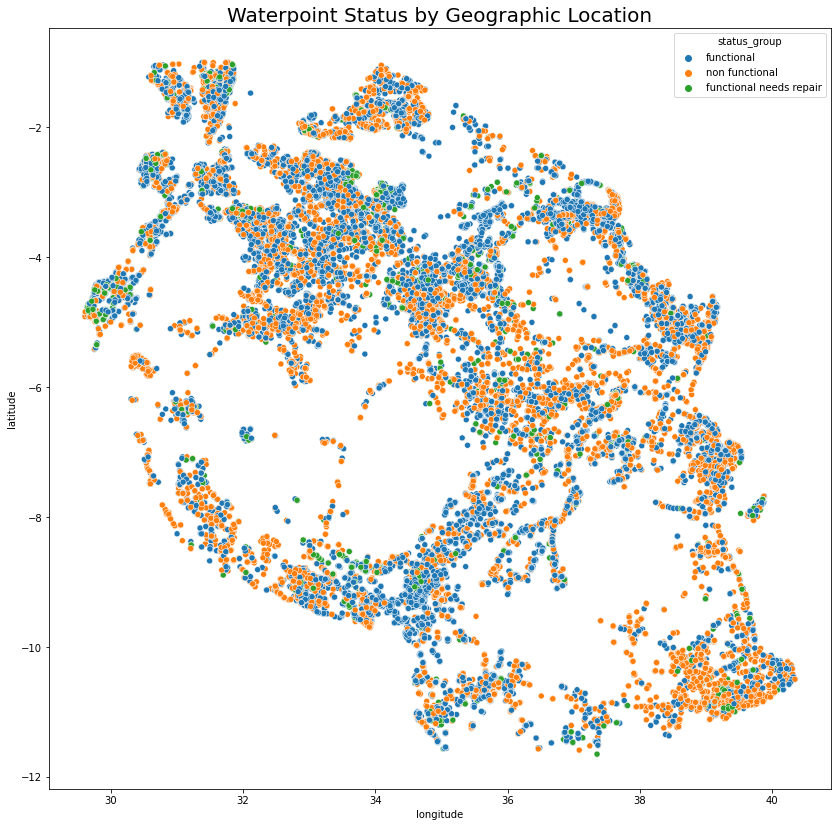

In [15]:
plt.figure(figsize = (14,14))
sns.scatterplot(x='longitude', y='latitude', hue='status_group', data=df)
plt.title('Waterpoint Status by Geographic Location', fontsize=20)
plt.savefig('Location Map')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57587 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             57587 non-null  float64
 1   date_recorded          57587 non-null  object 
 2   funder                 53965 non-null  object 
 3   gps_height             57587 non-null  int64  
 4   installer              53951 non-null  object 
 5   longitude              57587 non-null  float64
 6   latitude               57587 non-null  float64
 7   wpt_name               57587 non-null  object 
 8   num_private            57587 non-null  int64  
 9   basin                  57587 non-null  object 
 10  subvillage             57216 non-null  object 
 11  region                 57587 non-null  object 
 12  region_code            57587 non-null  int64  
 13  district_code          57587 non-null  int64  
 14  lga                    57587 non-null  object 
 15  wa

In [17]:
#date_recorded is an object. Chnaging to datetime
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['date_recorded'] = df['date_recorded'].map(dt.datetime.toordinal)

In [18]:
df.date_recorded.head()

0    734210
1    734933
2    734924
3    734896
4    734331
Name: date_recorded, dtype: int64

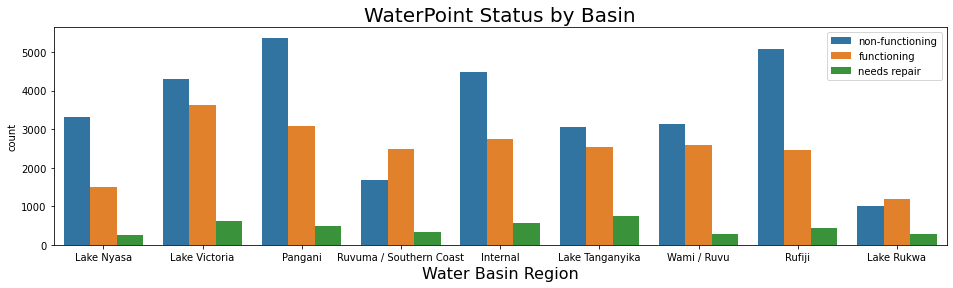

In [19]:

plt.figure(figsize=(16,4))
ax = sns.countplot(x="basin", hue='status_group', data=df)
plt.xlabel('Water Basin Region', fontsize=16)
plt.title("WaterPoint Status by Basin", fontsize=20)
labels = ['non-functioning', 'functioning', 'needs repair']
plt.legend(labels)
plt.show()

## Continuous variable cleaning

<AxesSubplot:>

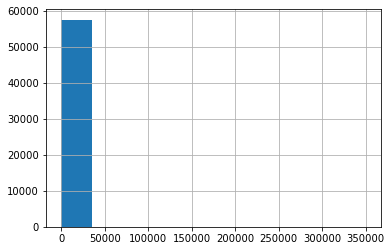

In [20]:
df.amount_tsh.hist()

In [21]:
df.amount_tsh.value_counts(normalize=True)

0.0         0.691580
500.0       0.053866
50.0        0.042926
1000.0      0.025839
20.0        0.025405
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64

Most values are 0. Seems to be some outliers making the hist hard to read. Removing outliers

In [22]:
amount_tsh_std = df.amount_tsh.mean() + df.amount_tsh.std()*3
amount_tsh_std
# Showing how many we are removing for reference
print("Outliers:", df.amount_tsh[df['amount_tsh'] > amount_tsh_std].count())
# Remove outliers from the data
df = df[df['amount_tsh'] < amount_tsh_std]

Outliers: 237


<AxesSubplot:>

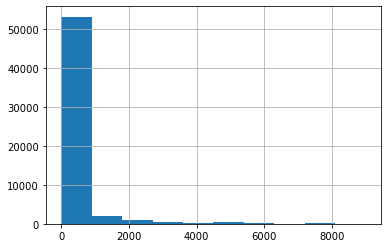

In [23]:
df.amount_tsh.hist()

In [24]:
df.describe()

,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,57350.000000,57350.000000,57350.00000,57350.000000,57350.000000,57350.000000,57350.00000,57350.000000,57350.000000,57350.000000
mean,220.729431,734587.341883,687.53299,35.145596,-5.883289,0.484882,15.24211,5.736059,185.266417,1339.229991
std,770.155360,335.843580,693.40072,2.608792,2.810017,12.430483,17.87787,9.761916,478.153756,938.485335
min,0.000000,731137.000000,-90.00000,29.607122,-11.649440,0.000000,1.00000,0.000000,0.000000,0.000000
25%,0.000000,734226.000000,0.00000,33.280201,-8.640322,0.000000,5.00000,2.000000,0.000000,0.000000
50%,0.000000,734784.000000,421.00000,35.000347,-5.168022,0.000000,12.00000,3.000000,35.000000,1988.000000
75%,25.000000,734908.000000,1331.00000,37.231554,-3.373151,0.000000,17.00000,5.000000,230.000000,2004.000000
max,9000.000000,735205.000000,2770.00000,40.345193,-0.998464,1776.000000,99.00000,80.000000,30500.000000,2013.000000


### gps_height

<AxesSubplot:>

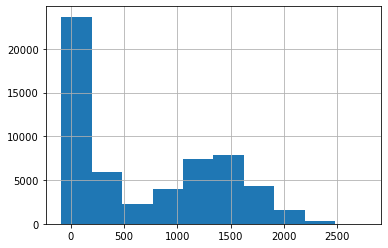

In [25]:
df.gps_height.hist()

In [26]:
df.gps_height.describe()

count    57350.00000
mean       687.53299
std        693.40072
min        -90.00000
25%          0.00000
50%        421.00000
75%       1331.00000
max       2770.00000
Name: gps_height, dtype: float64

In [27]:
gps_height_std = df.gps_height.mean() + df.gps_height.std()*3
gps_height_std
# Showing how many we are removing for reference
print("Outliers:", df.gps_height[df['gps_height'] > gps_height_std].count())
# Remove outliers from the data
df = df[df['gps_height'] < gps_height_std]

Outliers: 1


### num_private

There is no description for this column.

In [28]:
#Drop this because it is  almost constant
df.num_private.value_counts(normalize=True)

0      0.986922
6      0.001412
1      0.001255
5      0.000802
8      0.000802
         ...   
180    0.000017
213    0.000017
23     0.000017
55     0.000017
94     0.000017
Name: num_private, Length: 65, dtype: float64

<AxesSubplot:>

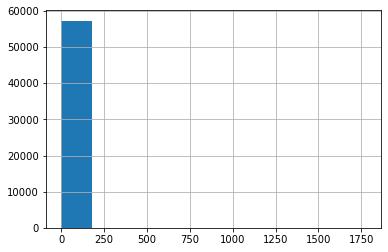

In [29]:
df.num_private.hist()

In [30]:
df = df.drop('num_private', axis=1)

### region_code, district_code both are prob cat

In [31]:
df.region_code.describe()

count    57349.000000
mean        15.242341
std         17.877940
min          1.000000
25%          5.000000
50%         12.000000
75%         17.000000
max         99.000000
Name: region_code, dtype: float64

### Population

population around the well

In [32]:
df.population.value_counts(normalize=True)

0       0.340651
1       0.122060
200     0.033741
150     0.032485
250     0.029259
          ...   
363     0.000017
491     0.000017
2570    0.000017
587     0.000017
1439    0.000017
Name: population, Length: 1042, dtype: float64

A lot of 0 values. Abandoned? Surely not. 

In [33]:
df.population.describe()

count    57349.000000
mean       185.269630
std        478.157306
min          0.000000
25%          0.000000
50%         35.000000
75%        230.000000
max      30500.000000
Name: population, dtype: float64

In [34]:
df.population.median()

35.0

I think I'll replace the 0 values with the median. Will do this after split

In [35]:
df.population.replace(0,df.population.median(axis=0),inplace=True)


In [36]:
df.population.describe()

count    57349.000000
mean       197.192418
std        473.805467
min          1.000000
25%         35.000000
50%         35.000000
75%        230.000000
max      30500.000000
Name: population, dtype: float64

In [35]:
population_std = df.population.mean() + df.population.std()*3
population_std
# Showing how many we are removing for reference
print("Outliers:", df.population[df['population'] > population_std].count())
# Remove outliers from the data
df = df[df['population'] < population_std]

Outliers: 702


### construction_year

In [36]:
df.construction_year.value_counts(normalize=True)

0       0.332921
2010    0.045104
2008    0.045033
2009    0.043639
2000    0.036154
2007    0.027574
2006    0.025156
2003    0.022243
2011    0.021572
2004    0.019471
2012    0.018783
1978    0.018130
2002    0.017883
2005    0.017494
1995    0.016929
1999    0.016929
1998    0.016629
1990    0.016629
1985    0.016312
1980    0.014158
1996    0.013787
1984    0.013416
1982    0.012869
1994    0.012587
1972    0.012357
1974    0.011580
1997    0.011210
1992    0.011033
1993    0.010451
2001    0.009356
1988    0.009091
1983    0.008438
1975    0.007573
1986    0.007538
1976    0.007220
1970    0.007167
1991    0.005649
1989    0.005490
1987    0.005190
1981    0.004148
1977    0.003548
1979    0.003354
1973    0.003195
2013    0.003107
1971    0.002507
1960    0.001801
1967    0.001553
1963    0.001465
1968    0.001324
1969    0.001024
1964    0.000706
1962    0.000530
1961    0.000371
1965    0.000335
1966    0.000282
Name: construction_year, dtype: float64

Once agiain a lot of 0's here

In [37]:
year = df[df['construction_year'] != 0]

In [38]:
year.construction_year.describe()

count    37788.000000
mean      1996.768233
std         12.500440
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

<AxesSubplot:>

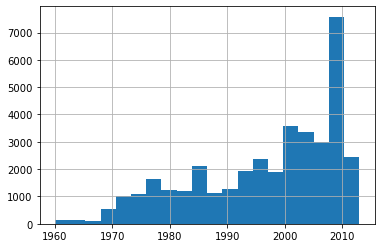

In [39]:
year.construction_year.hist(bins=20)

# Categorical Cleaning

In [40]:
df.isna().sum()

amount_tsh                  0
date_recorded               0
funder                   3588
gps_height                  0
installer                3602
longitude                   0
latitude                    0
wpt_name                    0
basin                       0
subvillage                371
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           2929
recorded_by                 0
scheme_management        3679
permit                   2997
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_typ

### funder

In [41]:
df.funder.describe()

count                      53059
unique                      1823
top       Government Of Tanzania
freq                        8784
Name: funder, dtype: object

In [42]:
#tons of unique/missing values. Dropping and focusing on others
df =df.drop('funder', axis=1)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56647 entries, 0 to 59399
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             56647 non-null  float64
 1   date_recorded          56647 non-null  int64  
 2   gps_height             56647 non-null  int64  
 3   installer              53045 non-null  object 
 4   longitude              56647 non-null  float64
 5   latitude               56647 non-null  float64
 6   wpt_name               56647 non-null  object 
 7   basin                  56647 non-null  object 
 8   subvillage             56276 non-null  object 
 9   region                 56647 non-null  object 
 10  region_code            56647 non-null  int64  
 11  district_code          56647 non-null  int64  
 12  lga                    56647 non-null  object 
 13  ward                   56647 non-null  object 
 14  population             56647 non-null  int64  
 15  pu

### Installer

In [44]:
df.installer.describe()

count     53045
unique     2069
top         DWE
freq      16051
Name: installer, dtype: object

In [45]:
#Dropping for same reeason. 
df = df.drop('installer', axis=1)

### wpt_name

This is just the name of the waterpoint. Dropping because should be irrelevant

In [46]:
df = df.drop('wpt_name', axis=1)

### Basin

In [47]:
df.basin.describe()

count       56647
unique          9
top       Pangani
freq         8805
Name: basin, dtype: object

In [48]:
df.basin.value_counts(normalize=True)

Pangani                    0.155436
Lake Victoria              0.148393
Rufiji                     0.139054
Internal                   0.135541
Lake Tanganyika            0.109732
Wami / Ruvu                0.102742
Lake Nyasa                 0.088760
Ruvuma / Southern Coast    0.077798
Lake Rukwa                 0.042544
Name: basin, dtype: float64

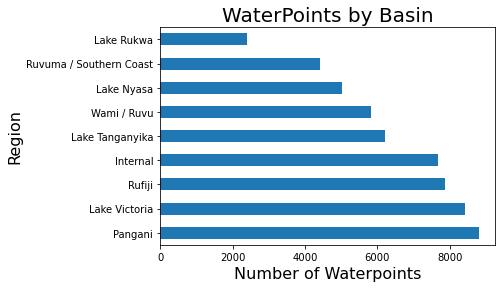

In [49]:
df.basin.value_counts().plot(kind='barh')
plt.xlabel('Number of Waterpoints', fontsize=16)
plt.ylabel('Region', fontsize=16)
plt.title("WaterPoints by Basin", fontsize=20)
plt.show()

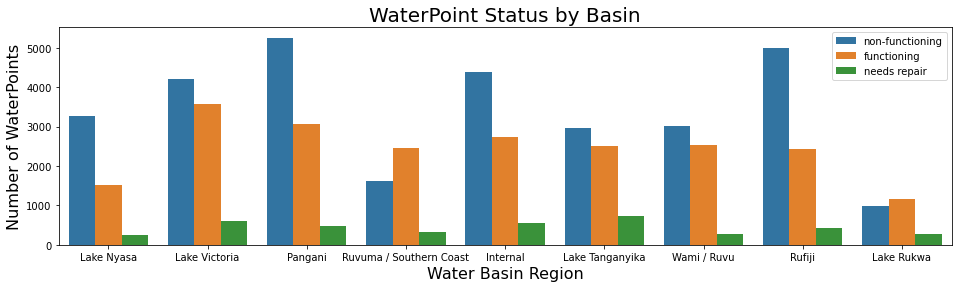

In [50]:

plt.figure(figsize=(16,4))
ax = sns.countplot(x="basin", hue='status_group', data=df)
plt.xlabel('Water Basin Region', fontsize=16)
plt.ylabel('Number of WaterPoints', fontsize=16)
plt.title("WaterPoint Status by Basin", fontsize=20)
labels = ['non-functioning', 'functioning', 'needs repair']
plt.legend(labels)
plt.show()

### subvillage

In [51]:
df.subvillage.describe()

count       56276
unique      18348
top       Shuleni
freq          482
Name: subvillage, dtype: object

In [52]:
df = df.drop('subvillage', axis=1)

### Region

In [53]:
df.region.describe()

count      56647
unique        21
top       Iringa
freq        5249
Name: region, dtype: object

In [54]:
#already have region code which is the same thing. Dropping
df =df.drop('region', axis=1)

Looking at the data a bit, I'm going to drop lga and ward as well for similar reasons. Too many geograghic features

In [55]:
df = df.drop(columns='lga', axis=1)
df = df.drop(columns='ward', axis=1)


### public_meeting

Whether the waterpoint is open to the public

some missing values

In [56]:
df.public_meeting.describe()

count     53718
unique        2
top        True
freq      48953
Name: public_meeting, dtype: object

In [57]:
df.public_meeting.value_counts(normalize=True)

True     0.911296
False    0.088704
Name: public_meeting, dtype: float64

Almost all are open to public. Going to fill missing values with true

In [58]:
df['public_meeting'].fillna(True, inplace=True)

### recorded_by

In [59]:
df.recorded_by.describe()

count                       56647
unique                          1
top       GeoData Consultants Ltd
freq                        56647
Name: recorded_by, dtype: object

All recorded by the same group. Removing since this won't be useful

In [60]:
df = df.drop('recorded_by', axis=1)

### Scheme_management

In [61]:
df.scheme_management.describe()

count     52968
unique       12
top         VWC
freq      35613
Name: scheme_management, dtype: object

In [62]:
df.scheme_management.value_counts()

VWC                 35613
WUG                  4205
Water authority      3081
WUA                  2847
Water Board          2717
Parastatal           1579
Private operator     1034
Company              1034
Other                 691
SWC                    96
Trust                  70
None                    1
Name: scheme_management, dtype: int64

In [63]:
#Dropping for same reason as many above
df = df.drop('scheme_management', axis=1)

### permit

In [64]:
df.permit.value_counts()

True     37526
False    16124
Name: permit, dtype: int64

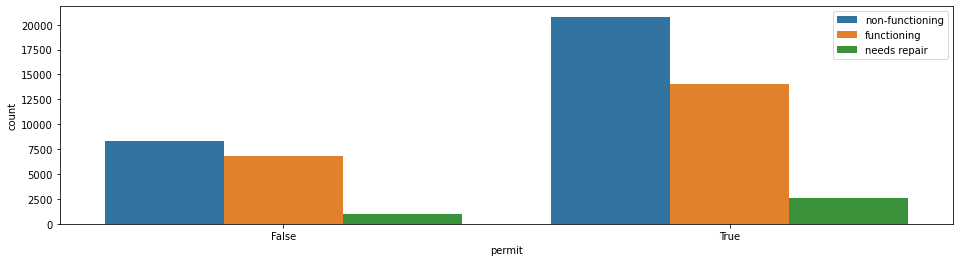

In [65]:

plt.figure(figsize=(16,4))
ax = sns.countplot(x="permit", hue='status_group', data=df)
labels = ['non-functioning', 'functioning', 'needs repair']
plt.legend(labels)
plt.show()

Weird. I expected those with permits to be more regulated than those without

There are some missing values here. Filling them with false.

In [66]:
df['permit'].fillna(False, inplace=True)

### extraction

These 3 seem to have similar data. 

In [67]:
df.extraction_type.value_counts()

gravity                      26389
nira/tanira                   7269
other                         6050
submersible                   4535
swn 80                        3404
mono                          2767
india mark ii                 2206
afridev                       1609
ksb                           1331
other - rope pump              444
other - swn 81                 224
windmill                       107
cemo                            90
india mark iii                  87
other - play pump               81
climax                          32
walimi                          20
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [68]:
df.extraction_type_group.value_counts()

gravity            26389
nira/tanira         7269
other               6050
submersible         5866
swn 80              3404
mono                2767
india mark ii       2206
afridev             1609
rope pump            444
other handpump       327
other motorpump      122
wind-powered         107
india mark iii        87
Name: extraction_type_group, dtype: int64

In [69]:
df.extraction_type_class.value_counts()

gravity         26389
handpump        14902
other            6050
submersible      5866
motorpump        2889
rope pump         444
wind-powered      107
Name: extraction_type_class, dtype: int64

Going to keep class and drop the other two. 


In [70]:
df = df.drop(columns=['extraction_type', 'extraction_type_group'], axis=1)

In [71]:
#putting low cardinality into other group
df.extraction_type_class = df.extraction_type_class.replace(to_replace = 
                                                            ['rope pump', 
                                                             'wind-powered'], 
                                                            value = 'other')
df.extraction_type_class.value_counts()

gravity        26389
handpump       14902
other           6601
submersible     5866
motorpump       2889
Name: extraction_type_class, dtype: int64

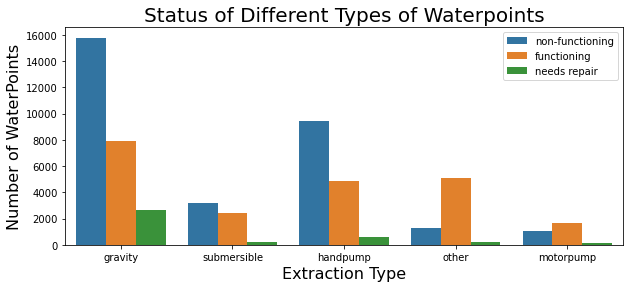

In [72]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x="extraction_type_class", hue='status_group', data=df)
plt.xlabel('Extraction Type', fontsize=16)
plt.ylabel('Number of WaterPoints', fontsize=16)
plt.title("Status of Different Types of Waterpoints", fontsize=20)
labels = ['non-functioning', 'functioning', 'needs repair']
plt.legend(labels)
plt.show()

### management

In [73]:
df.management.value_counts()

vwc                 39119
wug                  5498
water board          2888
wua                  2509
private operator     1923
parastatal           1660
water authority       881
other                 791
company               663
unknown               541
other - school         98
trust                  76
Name: management, dtype: int64

In [74]:
df.management_group.value_counts()

user-group    50014
commercial     3543
parastatal     1660
other           889
unknown         541
Name: management_group, dtype: int64

In [75]:
df = df.drop('management', axis=1)

In [76]:
df.management_group = df.management_group.replace(to_replace = ['unknown'],
                                                value = 'other')
df.management_group.value_counts()

user-group    50014
commercial     3543
parastatal     1660
other          1430
Name: management_group, dtype: int64

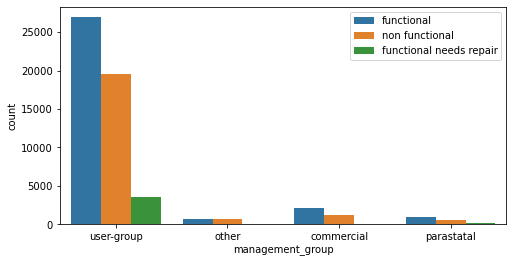

In [77]:

plt.figure(figsize=(8,4))
ax = sns.countplot(x="management_group", hue='status_group', data=df)
plt.legend()

### Payment

In [78]:
df.payment.value_counts()

never pay                24097
pay per bucket            8707
pay monthly               8059
unknown                   7582
pay when scheme fails     3804
pay annually              3506
other                      892
Name: payment, dtype: int64

In [79]:
df.payment_type.value_counts()

never pay     24097
per bucket     8707
monthly        8059
unknown        7582
on failure     3804
annually       3506
other           892
Name: payment_type, dtype: int64

In [80]:
#Looks liek a duplicate column. Removing extra
df = df.drop('payment_type', axis=1)

In [81]:
# group 'unknowns' and 'other' together to reduce bins
df.payment = df.payment.replace(to_replace = ['other'],
                                              value = 'unknown')
df.payment.value_counts()

never pay                24097
pay per bucket            8707
unknown                   8474
pay monthly               8059
pay when scheme fails     3804
pay annually              3506
Name: payment, dtype: int64

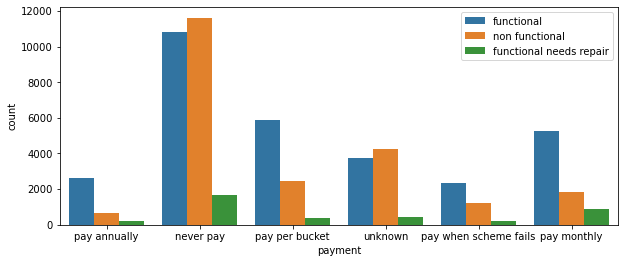

In [82]:

plt.figure(figsize=(10,4))
ax = sns.countplot(x="payment", hue='status_group', data=df)
plt.legend()

### Water Quality

In [83]:
df.quality_group.value_counts()

good        48664
salty        4862
unknown      1646
milky         798
colored       473
fluoride      204
Name: quality_group, dtype: int64

These are almost identical. Just notes the abandoned. Dropping former

In [84]:
df = df.drop('quality_group', axis=1)

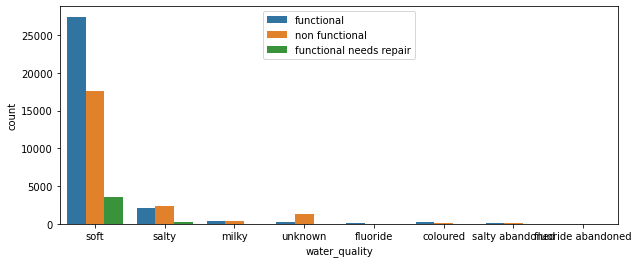

In [85]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x="water_quality", hue='status_group', data=df)
plt.legend()

In [86]:
# Group all to make it wither good or bad water
df.water_quality = df.water_quality.replace(to_replace = ['salty', 'milky', 'unknown', 
                                            'fluoride', 'coloured','salty abandoned', 
                                            'fluoride abandoned'], 
                                                value = 'other')
df.water_quality.value_counts()

soft     48664
other     7983
Name: water_quality, dtype: int64

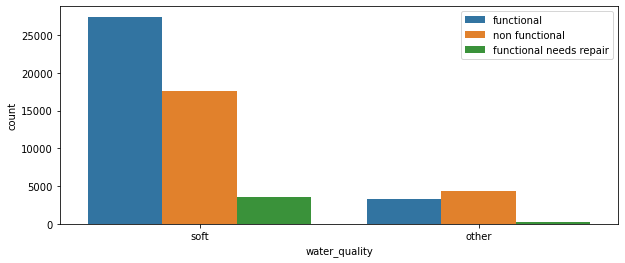

In [87]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x="water_quality", hue='status_group', data=df)
plt.legend()

### Quantity

In [88]:
df.quantity.value_counts()

enough          31684
insufficient    14302
dry              5934
seasonal         3965
unknown           762
Name: quantity, dtype: int64

In [89]:
df.quantity_group.value_counts()

enough          31684
insufficient    14302
dry              5934
seasonal         3965
unknown           762
Name: quantity_group, dtype: int64

In [90]:
#duplicated columns
df = df.drop('quantity_group', axis=1)

In [91]:
# changing groups to either sufficient or not
df.quantity = df.quantity.replace(to_replace = ['unknown', 'dry', 
                                                        'seasonal'], 
                                                value = 'insufficient')
df.quantity.value_counts()

enough          31684
insufficient    24963
Name: quantity, dtype: int64

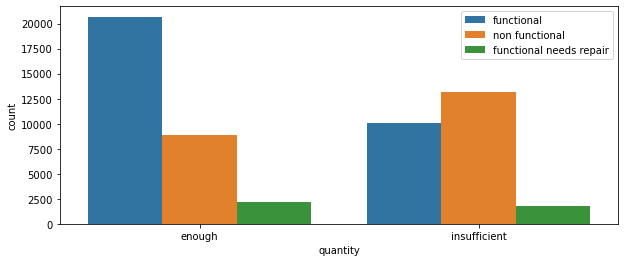

In [92]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x="quantity", hue='status_group', data=df)
plt.legend()

### Source

In [93]:
df.source.value_counts()

spring                  16833
shallow well            15288
machine dbh             10555
river                    9409
rainwater harvesting     2194
hand dtw                  864
dam                       621
lake                      620
other                     202
unknown                    61
Name: source, dtype: int64

In [94]:
df.source_class.value_counts()

groundwater    43540
surface        12844
unknown          263
Name: source_class, dtype: int64

In [95]:
df.source_type.value_counts()

spring                  16833
shallow well            15288
borehole                11419
river/lake              10029
rainwater harvesting     2194
dam                       621
other                     263
Name: source_type, dtype: int64

Looks like these three are redundant info dropping two

In [96]:
df = df.drop(columns=['source', 'source_type'], axis=1)

Most of the sources are from groundwater. Very little data in unknown cat

Putting those values under groundwater to reduce bins

In [97]:
df.source_class = df.source_class.replace(to_replace = 'unknown', 
                                                value = 'groundwater')
df.source_class.value_counts()

groundwater    43803
surface        12844
Name: source_class, dtype: int64

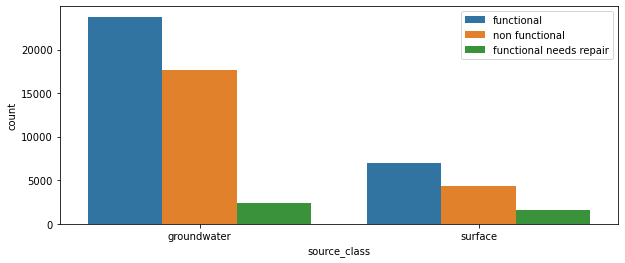

In [98]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x="source_class", hue='status_group', data=df)
plt.legend()

### Waterpoint Type

In [99]:
df.waterpoint_type_group.value_counts()

communal standpipe    33811
hand pump             15882
other                  6076
improved spring         767
cattle trough           105
dam                       6
Name: waterpoint_type_group, dtype: int64

In [100]:
df.waterpoint_type.value_counts()

communal standpipe             28012
hand pump                      15882
other                           6076
communal standpipe multiple     5799
improved spring                  767
cattle trough                    105
dam                                6
Name: waterpoint_type, dtype: int64

In [101]:
#dropping similar columns
df = df.drop('waterpoint_type_group', axis=1)

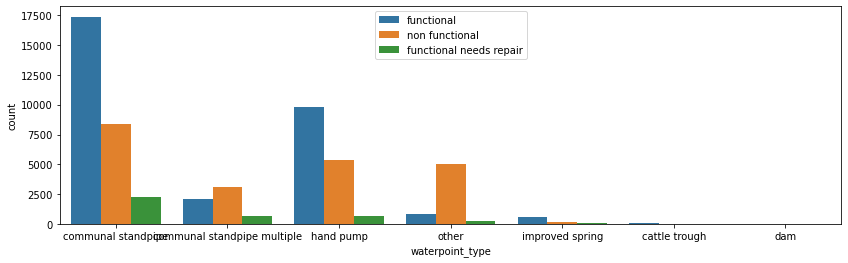

In [102]:
plt.figure(figsize=(14,4))
ax = sns.countplot(x="waterpoint_type", hue='status_group', data=df)
plt.legend()

I'm going to group some of these together

In [103]:
# all standpipes will be in a group
df.waterpoint_type = df.waterpoint_type.replace(to_replace = 'communal standpipe multiple', 
                                                value = 'communal standpipe')
df.waterpoint_type.value_counts()

communal standpipe    33811
hand pump             15882
other                  6076
improved spring         767
cattle trough           105
dam                       6
Name: waterpoint_type, dtype: int64

In [104]:
# Putting all the lower cardinality into the other group leaving only 3 columns
df.waterpoint_type = df.waterpoint_type.replace(to_replace = ['improved spring',
                                                   'cattle trough', 'dam'], 
                                                    value = 'other')
df.waterpoint_type.value_counts()

communal standpipe    33811
hand pump             15882
other                  6954
Name: waterpoint_type, dtype: int64

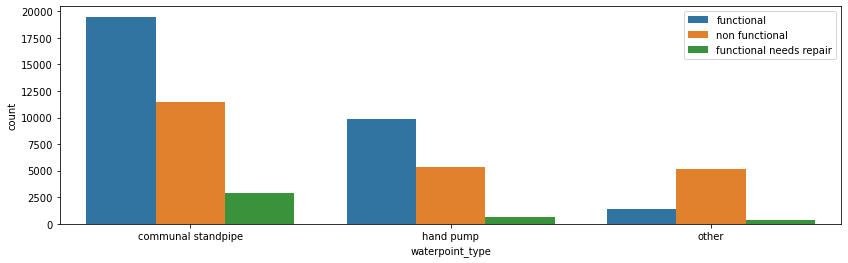

In [105]:
plt.figure(figsize=(14,4))
ax = sns.countplot(x="waterpoint_type", hue='status_group', data=df)
plt.legend()

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56647 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             56647 non-null  float64
 1   date_recorded          56647 non-null  int64  
 2   gps_height             56647 non-null  int64  
 3   longitude              56647 non-null  float64
 4   latitude               56647 non-null  float64
 5   basin                  56647 non-null  object 
 6   region_code            56647 non-null  int64  
 7   district_code          56647 non-null  int64  
 8   population             56647 non-null  int64  
 9   public_meeting         56647 non-null  bool   
 10  permit                 56647 non-null  bool   
 11  construction_year      56647 non-null  int64  
 12  extraction_type_class  56647 non-null  object 
 13  management_group       56647 non-null  object 
 14  payment                56647 non-null  object 
 15  wa

#### Cleaned Data

# One Hot Encoding Categoricals

In [107]:
cat_dummies = ['basin', 'public_meeting', 'permit',
       'extraction_type_class', 'management_group', 'payment', 'water_quality',
       'quantity', 'source_class', 'waterpoint_type']

In [108]:
enc = OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(df[['basin', 'public_meeting', 'permit',
       'extraction_type_class', 'management_group', 'payment', 'water_quality',
       'quantity', 'source_class', 'waterpoint_type']]).toarray())
# merge with main df bridge_df on key values
#bridge_df = bridge_df.join(enc_df)
#bridge_df

In [109]:
enc.get_feature_names()
enc_df.columns = enc.get_feature_names()

In [110]:
enc_df.head()

,x0_Internal,x0_Lake Nyasa,x0_Lake Rukwa,x0_Lake Tanganyika,x0_Lake Victoria,x0_Pangani,x0_Rufiji,x0_Ruvuma / Southern Coast,x0_Wami / Ruvu,x1_False,...,x5_unknown,x6_other,x6_soft,x7_enough,x7_insufficient,x8_groundwater,x8_surface,x9_communal standpipe,x9_hand pump,x9_other
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [111]:
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56647 entries, 0 to 56646
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   x0_Internal                 56647 non-null  float64
 1   x0_Lake Nyasa               56647 non-null  float64
 2   x0_Lake Rukwa               56647 non-null  float64
 3   x0_Lake Tanganyika          56647 non-null  float64
 4   x0_Lake Victoria            56647 non-null  float64
 5   x0_Pangani                  56647 non-null  float64
 6   x0_Rufiji                   56647 non-null  float64
 7   x0_Ruvuma / Southern Coast  56647 non-null  float64
 8   x0_Wami / Ruvu              56647 non-null  float64
 9   x1_False                    56647 non-null  float64
 10  x1_True                     56647 non-null  float64
 11  x2_False                    56647 non-null  float64
 12  x2_True                     56647 non-null  float64
 13  x3_gravity                  566

In [112]:
df2 = df.drop(columns=['basin', 'public_meeting', 'permit',
       'extraction_type_class', 'management_group', 'payment', 'water_quality',
       'quantity', 'source_class', 'waterpoint_type'], axis=1)

In [113]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56647 entries, 0 to 59399
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         56647 non-null  float64
 1   date_recorded      56647 non-null  int64  
 2   gps_height         56647 non-null  int64  
 3   longitude          56647 non-null  float64
 4   latitude           56647 non-null  float64
 5   region_code        56647 non-null  int64  
 6   district_code      56647 non-null  int64  
 7   population         56647 non-null  int64  
 8   construction_year  56647 non-null  int64  
 9   status_group       56647 non-null  object 
dtypes: float64(3), int64(6), object(1)
memory usage: 7.3+ MB


In [114]:
df3 = df2.join(enc_df, how='left')

In [115]:
df3.columns

Index(['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude',
       'region_code', 'district_code', 'population', 'construction_year',
       'status_group', 'x0_Internal', 'x0_Lake Nyasa', 'x0_Lake Rukwa',
       'x0_Lake Tanganyika', 'x0_Lake Victoria', 'x0_Pangani', 'x0_Rufiji',
       'x0_Ruvuma / Southern Coast', 'x0_Wami / Ruvu', 'x1_False', 'x1_True',
       'x2_False', 'x2_True', 'x3_gravity', 'x3_handpump', 'x3_motorpump',
       'x3_other', 'x3_submersible', 'x4_commercial', 'x4_other',
       'x4_parastatal', 'x4_user-group', 'x5_never pay', 'x5_pay annually',
       'x5_pay monthly', 'x5_pay per bucket', 'x5_pay when scheme fails',
       'x5_unknown', 'x6_other', 'x6_soft', 'x7_enough', 'x7_insufficient',
       'x8_groundwater', 'x8_surface', 'x9_communal standpipe', 'x9_hand pump',
       'x9_other'],
      dtype='object')

In [116]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56647 entries, 0 to 59399
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   amount_tsh                  56647 non-null  float64
 1   date_recorded               56647 non-null  int64  
 2   gps_height                  56647 non-null  int64  
 3   longitude                   56647 non-null  float64
 4   latitude                    56647 non-null  float64
 5   region_code                 56647 non-null  int64  
 6   district_code               56647 non-null  int64  
 7   population                  56647 non-null  int64  
 8   construction_year           56647 non-null  int64  
 9   status_group                56647 non-null  object 
 10  x0_Internal                 54030 non-null  float64
 11  x0_Lake Nyasa               54030 non-null  float64
 12  x0_Lake Rukwa               54030 non-null  float64
 13  x0_Lake Tanganyika          540

In [117]:
df3 = df3.fillna(0.0)

In [155]:
df4 = df3[df3.status_group != 'functional needs repair']
#decided to drop the needs repair status. There are far less of these, and these are less important to the objective

In [119]:
df4.status_group.value_counts()

functional        30752
non functional    22002
Name: status_group, dtype: int64

## Split data into test and train

In [120]:
y = df4.status_group
X = df4.drop('status_group', axis=1)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39565, 46), (13189, 46), (39565,), (13189,))

# Models

### Random Forest

After tinking with this model quite a bit, these are the hyperparameter we ended up using.

In [202]:
forest_clf = RandomForestClassifier(random_state=42, max_depth=15,n_estimators=500, 
                                    min_samples_leaf=2,
                                   min_samples_split=2)
forest_model = forest_clf.fit(X_train, y_train)

forest_training_preds = forest_clf.predict(X_train)
forest_training_accuracy = accuracy_score(y_train, forest_training_preds)

forest_val_preds = forest_clf.predict(X_test) 
forest_val_accuracy = accuracy_score(y_test, forest_val_preds)




Forest Training Accuracy: 
Forest Validation accuracy: 


In [207]:
print(classification_report(y_test, forest_val_preds))
#test report

                precision    recall  f1-score   support

    functional       0.72      0.88      0.79      7754
non functional       0.75      0.52      0.61      5603

      accuracy                           0.73     13357
     macro avg       0.73      0.70      0.70     13357
  weighted avg       0.73      0.73      0.72     13357



In [208]:
print(classification_report(y_train, forest_training_preds))
#training report

                precision    recall  f1-score   support

    functional       0.81      0.95      0.87     23428
non functional       0.90      0.69      0.78     16642

      accuracy                           0.84     40070
     macro avg       0.86      0.82      0.83     40070
  weighted avg       0.85      0.84      0.84     40070



It does look like our model is overfitting a bit, but not too much. Accuracy is 73% vs the 85% from the training

In [205]:
print(confusion_matrix(y_test, forest_val_preds))

[[6797  957]
 [2693 2910]]


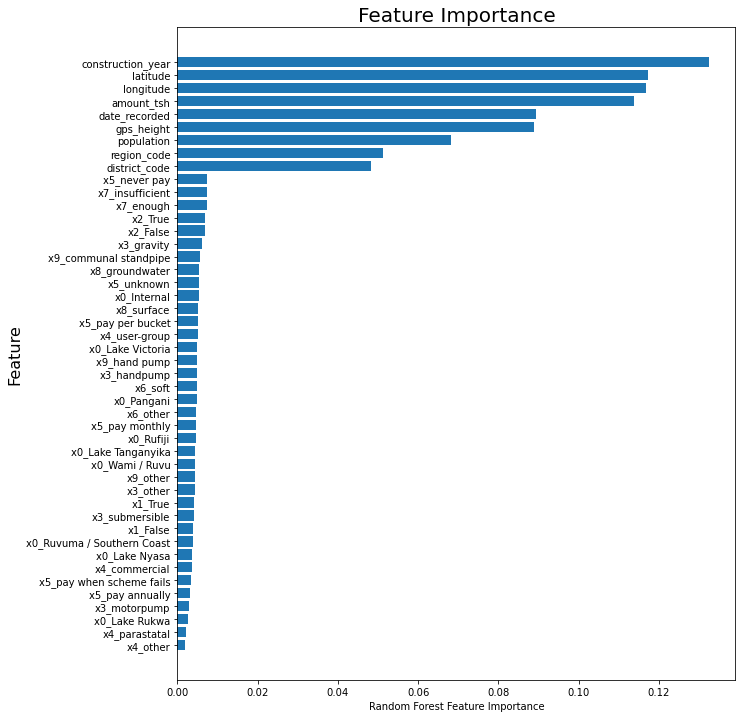

In [206]:
sorted_idx = forest_clf.feature_importances_.argsort()
plt.figure(figsize=(10,12))
plt.barh(X.columns[sorted_idx], forest_clf.feature_importances_[sorted_idx])
plt.ylabel('Feature', fontsize=16)
plt.title("Feature Importance", fontsize=20)
plt.xlabel("Random Forest Feature Importance")
plt.savefig('Feature Importance')

In [179]:
# Forst Model with GridSearch parameters
param_grid_2 = {
    'max_depth': [5, 10, 30, None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 5],
    'n_estimators': [10, 25, 100],
}

In [198]:
# GridSearch Classifier
# This time I'm going to try criterion='entropy'
forest_clf = RandomForestClassifier(random_state=42)
grid_clf = GridSearchCV(forest_clf, param_grid_2, scoring='accuracy', cv=3, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds_forest = grid_clf.predict(X_train)
training_accuracy_forest = accuracy_score(y_train, training_preds_forest)

val_preds_forest = grid_clf.predict(X_test)
val_accuracy_forest = accuracy_score(y_test, val_preds_forest)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy_forest * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy_forest * 100))

Grid Search found the following optimal parameters: 
max_depth: None
min_samples_leaf: 2
min_samples_split: 2
n_estimators: 100

Training Accuracy: 96.94%
Validation accuracy: 72.97%


In [182]:
# Classification report
print(classification_report(y_test, val_preds_forest))

                precision    recall  f1-score   support

    functional       0.73      0.84      0.78      7754
non functional       0.73      0.57      0.64      5603

      accuracy                           0.73     13357
     macro avg       0.73      0.71      0.71     13357
  weighted avg       0.73      0.73      0.72     13357



In [183]:
print(classification_report(y_train, training_preds_forest))

                precision    recall  f1-score   support

    functional       0.96      0.99      0.97     23428
non functional       0.98      0.94      0.96     16642

      accuracy                           0.97     40070
     macro avg       0.97      0.97      0.97     40070
  weighted avg       0.97      0.97      0.97     40070



After running several different grid searches, I still was having trouble with overfitting. I decided to go with the previous hyperparameters instead. 

### XGBoost


In [122]:
# XGB classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

xgb_training_preds = xgb_clf.predict(X_train)
xgb_training_accuracy = accuracy_score(y_train, xgb_training_preds)

xgb_val_preds = xgb_clf.predict(X_test)
xgb_val_accuracy = accuracy_score(y_test, xgb_val_preds)

print("XGB Training Accuracy: {:.4}%".format(xgb_training_accuracy * 100))
print("XGB Validation accuracy: {:.4}%".format(xgb_val_accuracy * 100))

XGB Training Accuracy: 81.52%
XGB Validation accuracy: 74.65%


In [123]:
print(classification_report(y_test, xgb_val_preds))

                precision    recall  f1-score   support

    functional       0.76      0.83      0.79      7694
non functional       0.73      0.63      0.67      5495

      accuracy                           0.75     13189
     macro avg       0.74      0.73      0.73     13189
  weighted avg       0.74      0.75      0.74     13189



In [124]:
print(classification_report(y_train, xgb_training_preds))

                precision    recall  f1-score   support

    functional       0.81      0.89      0.85     23058
non functional       0.82      0.71      0.76     16507

      accuracy                           0.82     39565
     macro avg       0.82      0.80      0.81     39565
  weighted avg       0.82      0.82      0.81     39565



Our model here is a bit better overall. It's a little more accurate, and overfits less

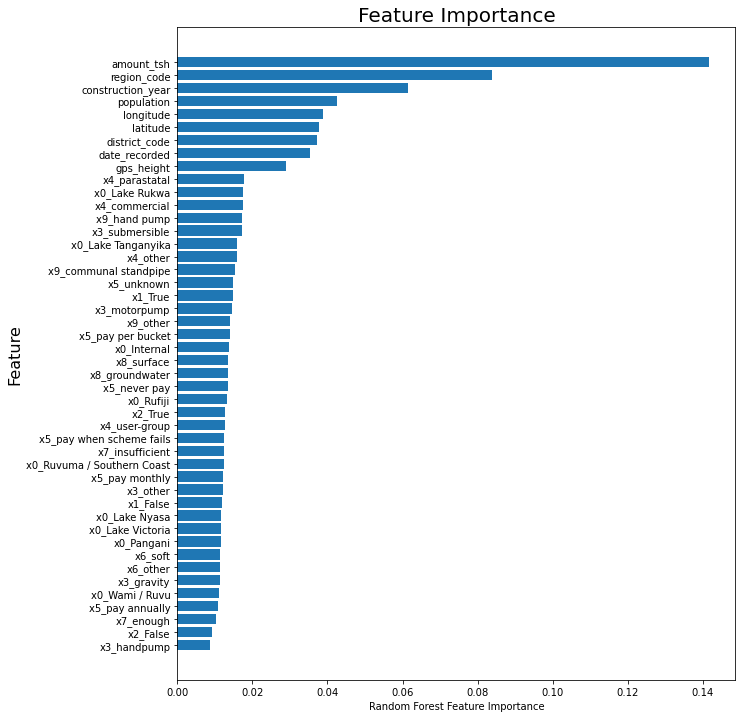

In [153]:
sorted_idx2 = xgb_clf.feature_importances_.argsort()
plt.figure(figsize=(10,12))
plt.barh(X.columns[sorted_idx2], xgb_clf.feature_importances_[sorted_idx2])
plt.ylabel('Feature', fontsize=16)
plt.title("Feature Importance", fontsize=20)
plt.xlabel("Random Forest Feature Importance")
plt.savefig('Feature Importance2')

### Decision Tree

In [150]:
tree = DecisionTreeClassifier(random_state=42)  
DTclf = tree.fit(X_train, y_train) 

tree_training_pred = tree.predict(X_train)
tree_training_accuracy = accuracy_score(y_train, tree_training_pred)

tree_val_preds = tree.predict(X_test)
tree_val_accuracy = accuracy_score(y_test, tree_val_preds)


In [152]:
print(classification_report(y_test, tree_val_preds))

                precision    recall  f1-score   support

    functional       0.75      0.75      0.75      7694
non functional       0.65      0.66      0.65      5495

      accuracy                           0.71     13189
     macro avg       0.70      0.70      0.70     13189
  weighted avg       0.71      0.71      0.71     13189



In [151]:
print(classification_report(y_train, tree_training_pred))

                precision    recall  f1-score   support

    functional       1.00      1.00      1.00     23058
non functional       1.00      1.00      1.00     16507

      accuracy                           1.00     39565
     macro avg       1.00      1.00      1.00     39565
  weighted avg       1.00      1.00      1.00     39565



# Conclusions


Our best model was the XGBoost. It was abe to correctly guess the waterpoint status 74% of the time.

The best most important feature for identifying the state of the wells were the amount of water available to the waterpoint.

Construction year and location was also important factors. 

# Recommendations

Look into these water points with low amounts of access to water. Why are these not getting the water they need? If we can give these wells better access to water, we should be able to solve a large portion of the problems.

There is definitely a pattern with location and the status of the wells. We saw this in the visualizations and in our models. Try to find why this is. Is it a problem with the local regulations or something larger?

The population surrounding the wells also seems to be important. A lower population probably means that there are less regulations and maintenance. These wells are still needed though. The government needs to focus on getting these wells back online. 

## Future Work


We focused solely on the functioning and non functioning wells, since it was the more pressing issue. In the future we need to also better recognize which wells need maintenance, so the gap does not increase.

This data only go up to 2013. Update the data with more recent well information.


